# Linear Regression With PySpark Using Boston Housing Data
#### Author: Aditya Wresniyandaka
#### Data source: http://lib.stat.cmu.edu/datasets/boston
## Load the Boston Housing data

In [1]:
# Create SQL Context from the SparkContext sc
from pyspark.sql import SQLContext, SparkSession
sqlContext = SQLContext(sc)

In [2]:
## Create a SparkSession app object
spark1 = SparkSession.builder.appName('housing').getOrCreate()

In [3]:
# Load the CSV into a Spark Dataframe
# Specify tab as the separator/delimiter
housing_df = spark1.read.csv('/home/aditya/Documents/MachineLearning/housing.csv', sep = "\t", 
                             inferSchema=True, header=True)

## Exploratory Data Analysis (EDA)

In [4]:
import pandas as pd
import numpy as np

In [5]:
# Let's look the data frame structure
housing_df.printSchema()

root
 |-- CRIM: double (nullable = true)
 |-- ZN: double (nullable = true)
 |-- INDUS: double (nullable = true)
 |-- CHAS: integer (nullable = true)
 |-- NOX: double (nullable = true)
 |-- RM: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- DIS: double (nullable = true)
 |-- RAD: integer (nullable = true)
 |-- TAX: integer (nullable = true)
 |-- PTRATIO: double (nullable = true)
 |-- B: double (nullable = true)
 |-- LSTAT: double (nullable = true)
 |-- MEDV: double (nullable = true)



In [6]:
# Or just check the data type
housing_df.dtypes

[('CRIM', 'double'),
 ('ZN', 'double'),
 ('INDUS', 'double'),
 ('CHAS', 'int'),
 ('NOX', 'double'),
 ('RM', 'double'),
 ('AGE', 'double'),
 ('DIS', 'double'),
 ('RAD', 'int'),
 ('TAX', 'int'),
 ('PTRATIO', 'double'),
 ('B', 'double'),
 ('LSTAT', 'double'),
 ('MEDV', 'double')]

### Take a look at the data using Pandas for a better formatting

In [7]:
housing_dfpd = housing_df.toPandas()
housing_dfpd.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [8]:
# Let's get some statistics of each feature
# Since there are many features, let's transpose it as well
housing_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
CRIM,506,3.6135235573122535,8.601545105332491,0.00632,88.9762
ZN,506,11.363636363636363,23.32245299451514,0.0,100.0
INDUS,506,11.136778656126504,6.860352940897589,0.46,27.74
CHAS,506,0.0691699604743083,0.2539940413404101,0,1
NOX,506,0.5546950592885372,0.11587767566755584,0.385,0.871
RM,506,6.284634387351787,0.7026171434153232,3.561,8.78
AGE,506,68.57490118577078,28.148861406903595,2.9,100.0
DIS,506,3.795042687747034,2.10571012662761,1.1296,12.1265
RAD,506,9.549407114624506,8.707259384239366,1,24


In [9]:
# Find the correlation among features.
# The target is MEDV (Median Values)
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
colnames = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 
            'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
vectorAssembler = VectorAssembler(inputCols = colnames, outputCol = 'features')
vhousing_df = vectorAssembler.transform(housing_df)
corr1 = Correlation.corr(vhousing_df, 'features').head()
print("Pearson correlation matrix:\n" + str(corr1[0]))


Pearson correlation matrix:
DenseMatrix([[ 1.        , -0.20046922,  0.40658341, -0.05589158,  0.42097171,
              -0.2192467 ,  0.35273425, -0.37967009,  0.62550515,  0.58276431,
               0.28994558, -0.38506394,  0.45562148, -0.38830461],
             [-0.20046922,  1.        , -0.53382819, -0.04269672, -0.51660371,
               0.31199059, -0.56953734,  0.66440822, -0.31194783, -0.31456332,
              -0.39167855,  0.17552032, -0.41299457,  0.36044534],
             [ 0.40658341, -0.53382819,  1.        ,  0.06293803,  0.76365145,
              -0.39167585,  0.64477851, -0.70802699,  0.59512927,  0.72076018,
               0.38324756, -0.35697654,  0.60379972, -0.48372516],
             [-0.05589158, -0.04269672,  0.06293803,  1.        ,  0.09120281,
               0.09125123,  0.08651777, -0.09917578, -0.00736824, -0.03558652,
              -0.12151517,  0.04878848, -0.0539293 ,  0.17526018],
             [ 0.42097171, -0.51660371,  0.76365145,  0.09120281,  1.   

### Plot the scatter matrix

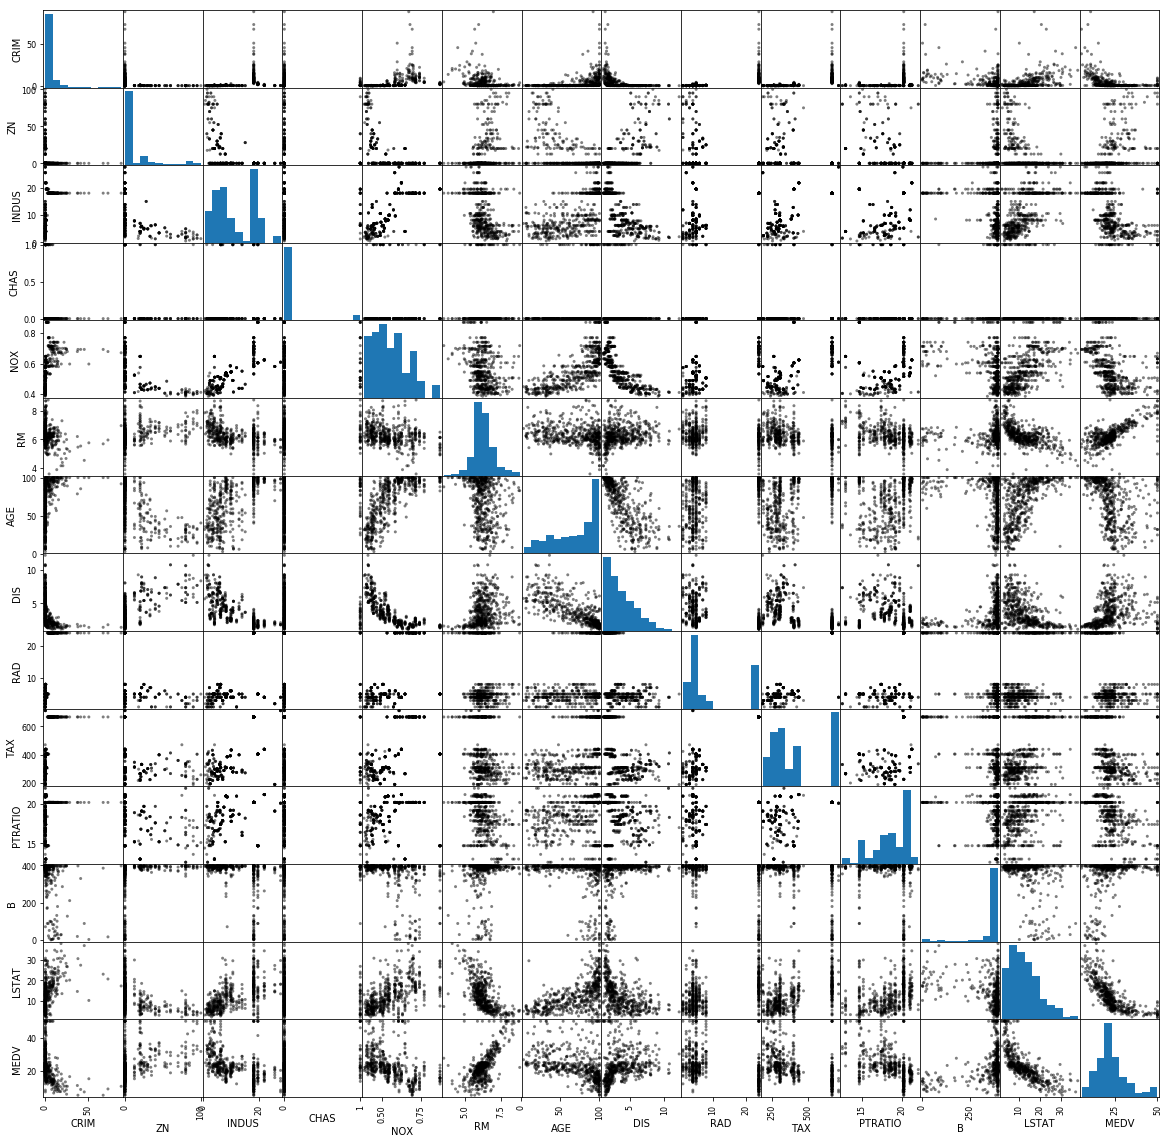

In [11]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

pd.plotting.scatter_matrix(housing_df.toPandas(), figsize=(20,20), color='black');

### By reviewing the above scatter matrix plot, especially the last column, we can see that RM has a positive correlation with MEDV, while LSTAT has a negative correlation.

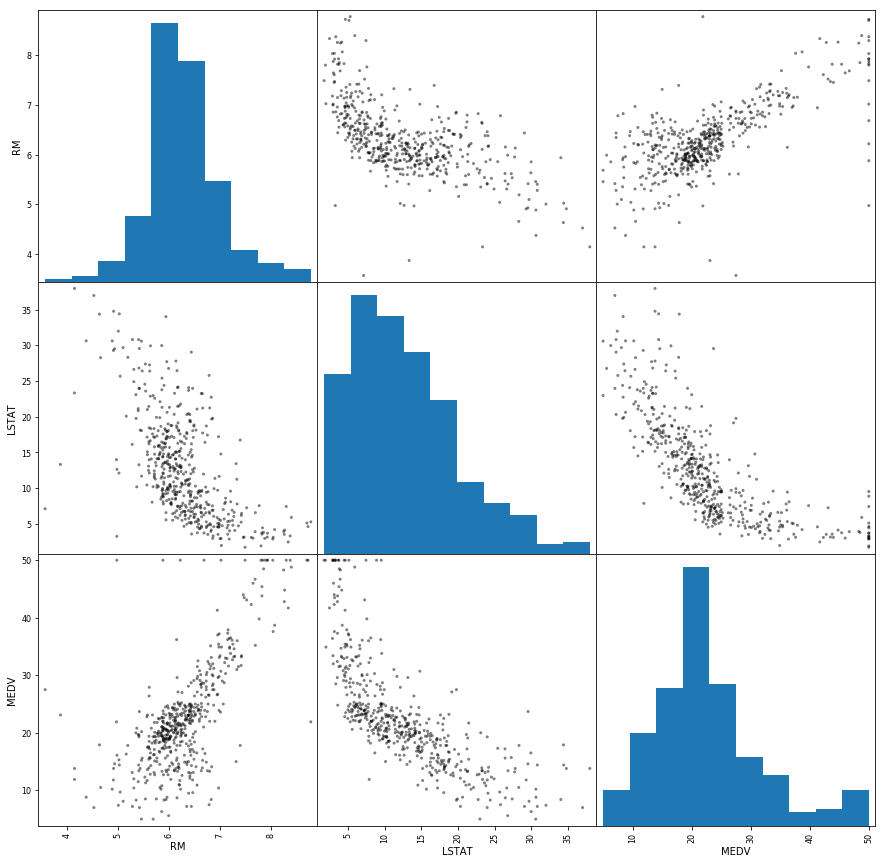

In [17]:
# Let's just select RM, LSTAT and MEDV to get a better picture
housing_df_select = housing_df.select('RM', 'LSTAT', 'MEDV')

pd.plotting.scatter_matrix(housing_df_select.toPandas(), figsize=(15,15), color='black');

### Plot the histogram of MEDV Median Housing values (the target feature)

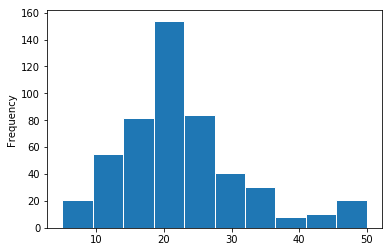

In [18]:
housing_dfpd['MEDV'].plot.hist(edgecolor='white');

### From the above histogram, we see outliers above USD 350K

### Let's remove MEDV above 35

In [19]:
## Use filtering in Spark
housing_df = housing_df.filter("MEDV <= 35.0")

### Check the histogram again to make sure the outliers are gone

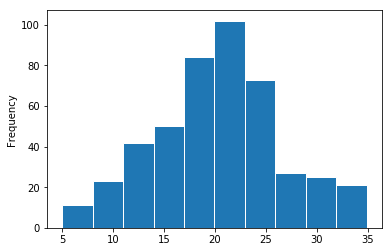

In [20]:
housing_dfpd = housing_df.toPandas()
housing_dfpd['MEDV'].plot.hist(edgecolor='white');

## Build a linear regression model
### Features selected are RM (strong positive correlation) and LSTAT (strong negative correlation), with the target is MEDV

### Based on RM (average number of rooms per dwelling)

In [21]:
## Build a linear regression model using RM = number of rooms in the house
colnames1 = ['RM']
vectorAssembler1 = VectorAssembler(inputCols = colnames1, outputCol = 'features')
vhouse_rm = vectorAssembler1.transform(housing_df['RM', 'MEDV'])
vhouse_rm
splits1 = vhouse_rm.randomSplit([0.8, 0.2], seed=123456789)
train_rm = splits1[0]
test_rm = splits1[1]

In [22]:
## Create a Linear Regression Model
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='MEDV', maxIter=10, regParam=0.3, elasticNetParam=0.8)
## Based on RM
rm_model = lr.fit(train_rm)
rm_coefficient = rm_model.coefficients.values[0]  ## Get the value from a Dense Vector
rm_intercept = rm_model.intercept
print("Coefficient:", rm_coefficient)
print("Intercept:", rm_intercept)
print("RMSE:", rm_model.summary.rootMeanSquaredError)

Coefficient: 6.028517623350395
Intercept: -17.061922440366263
RMSE: 5.057354514986854


In [23]:
## Let's predict with the test set
rm_predict = rm_model.transform(test_rm,)
rm_predict.select("prediction","MEDV","features").show(20)

+------------------+----+--------+
|        prediction|MEDV|features|
+------------------+----+--------+
|4.4056288163844926|27.5| [3.561]|
| 6.226241138636315|23.1| [3.863]|
| 12.85761052432175|21.9| [4.963]|
| 15.26298905603856|20.8| [5.362]|
|15.817612677386787|15.2| [5.454]|
|16.311951122501522|11.3| [5.536]|
|  16.6917477327726|13.9| [5.599]|
|16.727918838512704|18.5| [5.605]|
|17.354884671341143|19.4| [5.709]|
|17.547797235288353|18.7| [5.741]|
|17.981850504169582|14.5| [5.813]|
|18.108449374259937|19.9| [5.834]|
|18.126534927129992|10.2| [5.837]|
|18.204905656233546|21.0|  [5.85]|
| 18.22901972672695|22.7| [5.854]|
|18.349590079193955|20.3| [5.874]|
|18.355618596817312|17.4| [5.875]|
| 18.36767563206401|23.8| [5.877]|
| 18.41590377305081|20.9| [5.885]|
|18.433989325920866|23.3| [5.888]|
+------------------+----+--------+
only showing top 20 rows



In [24]:
## Evaluate RMSE against the test set
test_result = rm_model.evaluate(test_rm)
print("RMSE against test set:", test_result.rootMeanSquaredError)

RMSE against test set: 5.776765159591206


In [30]:
## Show residuals
rm_residuals = rm_model.summary.residuals
rm_residuals.take(10)

[Row(residuals=4.015916514942328),
 Row(residuals=5.915916514942328),
 Row(residuals=-0.4706425384282653),
 Row(residuals=-3.180948699554172),
 Row(residuals=7.061942879500631),
 Row(residuals=-0.4827415434597775),
 Row(residuals=-2.157243561583666),
 Row(residuals=-0.6958994669207215),
 Row(residuals=1.2860149802092273),
 Row(residuals=1.965444627742217)]

In [31]:
# Predictions
rm_predictions = rm_predict.select("prediction")
rm_MEDV = rm_predict.select("MEDV")
rm_RM = rm_predict.select("RM")

### Plot the actual versus predicted values based on the number of rooms in the house

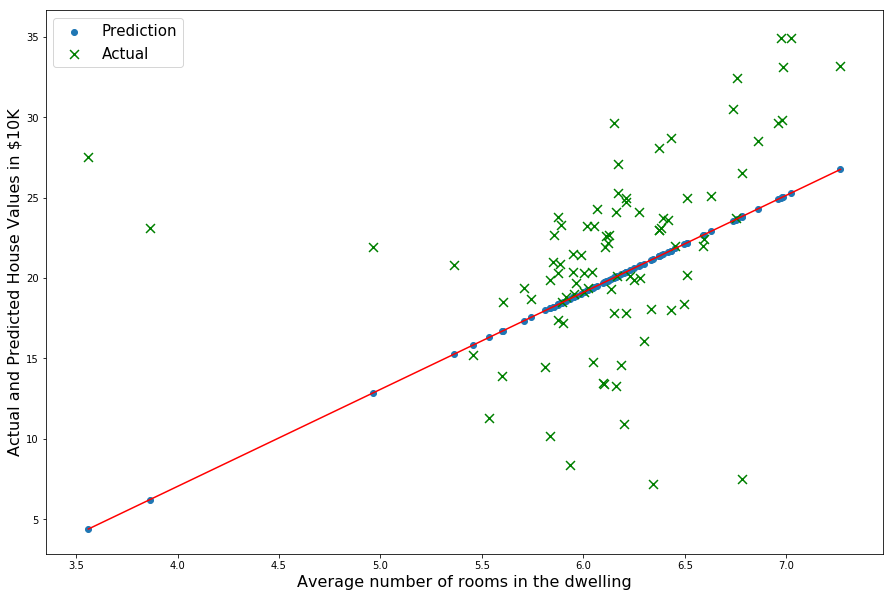

In [33]:
figure(figsize=(15,10))

# We calculate the slope and intercept for the actual and predicted values 
line = rm_coefficient * rm_RM.toPandas() + rm_intercept

plt.scatter(rm_RM.toPandas(), rm_predictions.toPandas(), label='Prediction')
plt.scatter(rm_RM.toPandas(), rm_MEDV.toPandas(), marker='x', s=80, c='green', label='Actual')
plt.plot(rm_RM.toPandas(), line, c='red')
plt.xlabel("Average number of rooms in the dwelling", fontsize = 16)
plt.ylabel("Actual and Predicted House Values in $10K", fontsize =16)
plt.legend(fontsize=15);

### Based on LSTAT (percentage values of lower status population)

In [34]:
colnames2 = ['LSTAT']
vectorAssembler2 = VectorAssembler(inputCols = colnames2, outputCol = 'features')
vhouse_lstat = vectorAssembler2.transform(housing_df['LSTAT', 'MEDV'])
vhouse_lstat
splits2 = vhouse_lstat.randomSplit([0.8, 0.2], seed=123456789)
train_lstat = splits2[0]
test_lstat = splits2[1]
vhouse_lstat

DataFrame[LSTAT: double, MEDV: double, features: vector]

In [35]:
## Create a Linear Regression Model
lr_stat = LinearRegression(featuresCol = 'features', labelCol='MEDV', maxIter=10, regParam=0.3, elasticNetParam=0.8)
## Based on RM
lstat_model = lr.fit(train_lstat)
lstat_coefficient = lstat_model.coefficients.values[0]  ## Get the value from a Dense Vector
lstat_intercept = lstat_model.intercept
print("Coefficient:", lstat_coefficient)
print("Intercept:", lstat_model.intercept)
print("RMSE:", lstat_model.summary.rootMeanSquaredError)

Coefficient: -0.6540044438460292
Intercept: 29.32199616904659
RMSE: 4.001207921687148


In [36]:
## Let's predict with the test set
lstat_predict = lstat_model.transform(test_lstat,)
lstat_predict.select("prediction","MEDV","features").show(20)

+------------------+----+--------+
|        prediction|MEDV|features|
+------------------+----+--------+
| 28.02706737023145|34.9|  [1.98]|
|27.399223104139264|33.4|  [2.94]|
|26.496696971631742|30.8|  [4.32]|
|26.071594083131824|22.5|  [4.97]|
|25.796912216716493|34.9|  [5.39]|
|25.711891639016507|22.8|  [5.52]|
|25.463369950355016|24.4|   [5.9]|
|25.404509550408875|24.5|  [5.99]|
|25.012106884101257|25.2|  [6.59]|
|24.920546261962812|22.2|  [6.73]|
|24.521603551216735|22.6|  [7.34]|
|24.462743151270594|24.1|  [7.43]|
| 24.41042279576291|22.9|  [7.51]|
|24.390802662447527|23.4|  [7.54]|
|24.286161951432163|20.4|   [7.7]|
|24.057260396086054|18.2|  [8.05]|
|24.057260396086054|29.0|  [8.05]|
|24.024560173893754|22.0|   [8.1]|
|23.808738707424563|23.4|  [8.43]|
| 23.75641835191688|20.6|  [8.51]|
+------------------+----+--------+
only showing top 20 rows



In [37]:
## Evaluate RMSE against the test set
lstat_test_result = lstat_model.evaluate(test_lstat)
print("RMSE against test set:", lstat_test_result.rootMeanSquaredError)

RMSE against test set: 3.3142058991823307


In [38]:
## Show residuals
lstat_residuals = lstat_model.summary.residuals
lstat_residuals.toPandas().size

368

In [39]:
# Predictions
lstat_predictions = lstat_predict.select("prediction")
lstat_MEDV = lstat_predict.select("MEDV")
lstat_LSTAT = lstat_predict.select("LSTAT")

### Plot the actual versus predicted values based on the percentage of lower status 

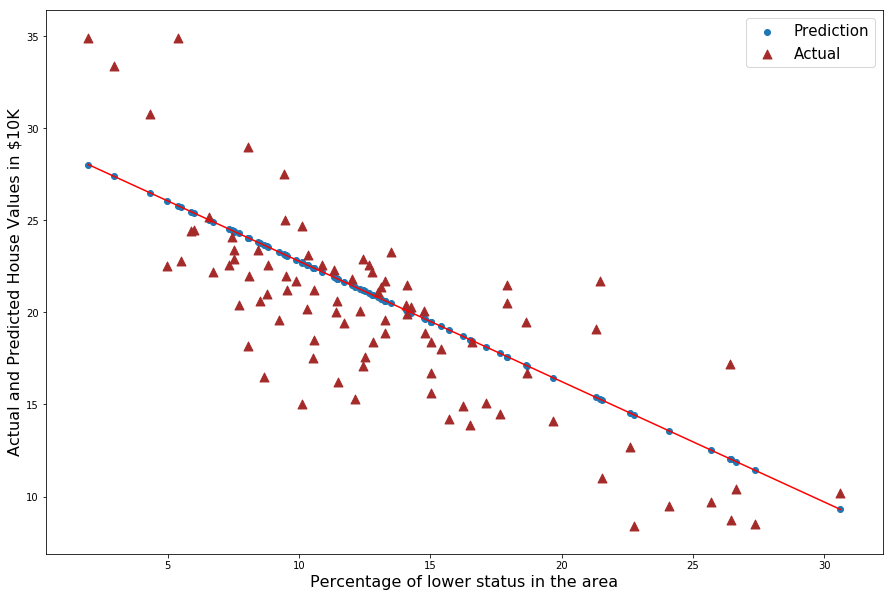

In [40]:
figure(figsize=(15,10))

line = lstat_coefficient * lstat_LSTAT.toPandas() + lstat_intercept

plt.scatter(lstat_LSTAT.toPandas(), lstat_predictions.toPandas(), label='Prediction')
plt.scatter(lstat_LSTAT.toPandas(), lstat_MEDV.toPandas(), marker='^', s=80, c='brown', label='Actual')
plt.plot(lstat_LSTAT.toPandas(), line, c='red')
plt.xlabel("Percentage of lower status in the area", fontsize = 16)
plt.ylabel("Actual and Predicted House Values in $10K", fontsize =16)
plt.legend(fontsize=15);

### We can see from the above chart that the Actual values don't quite follow a straight line.
### Let's try to change the values of LSTAT into log(LSTAT)

In [41]:
## Create a copy of the housing_df, modifying the value of LSTAT
import pyspark.sql.functions as sqlf
newhousing_df = housing_df.withColumn("LSTAT", sqlf.log10('LSTAT'));

### Check the value of LSTAT in the first row before and after the log10 is applied

In [42]:
print("LSTAT in the original dataframe: ", housing_df.take(1)[0]['LSTAT'])

LSTAT in the original dataframe:  4.98


In [43]:
print("LSTAT in the new dataframe after log10 is applied: ", newhousing_df.take(1)[0]['LSTAT'])

LSTAT in the new dataframe after log10 is applied:  0.6972293427597176


In [44]:
# Create the vector from the new dataframe
newvhouse_lstat = vectorAssembler2.transform(newhousing_df['LSTAT', 'MEDV'])
newvhouse_lstat
newsplits2 = newvhouse_lstat.randomSplit([0.8, 0.2], seed=123456789)
newtrain_lstat = newsplits2[0]
newtest_lstat = newsplits2[1]
newvhouse_lstat

DataFrame[LSTAT: double, MEDV: double, features: vector]

In [45]:
# Create a Linear Regression Model Using the new training dataset
lr_stat = LinearRegression(featuresCol = 'features', labelCol='MEDV', maxIter=10, regParam=0.3, elasticNetParam=0.8)
## Based on RM
newlstat_model = lr.fit(newtrain_lstat)
newlstat_coefficient = newlstat_model.coefficients.values[0]  ## Get the value from a Dense Vector
newlstat_intercept = newlstat_model.intercept
print("Coefficient:", newlstat_coefficient)
print("Intercept:", newlstat_model.intercept)
print("RMSE:", newlstat_model.summary.rootMeanSquaredError)

Coefficient: -20.51793340045634
Intercept: 42.41511052070428
RMSE: 3.7849997865694465


In [46]:
## Let's predict with the tnew est set
newlstat_predict = newlstat_model.transform(newtest_lstat,)
newlstat_predict.select("prediction","MEDV","features").show(20)

+------------------+----+--------------------+
|        prediction|MEDV|            features|
+------------------+----+--------------------+
| 36.32815390468448|34.9|[0.2966651902615311]|
| 32.80559118702612|33.4|[0.46834733041215...|
|29.376297326483456|30.8|[0.6354837468149122]|
| 28.12731651369149|22.5| [0.696356388733332]|
|27.404420960080685|34.9|[0.7315887651867387]|
|27.192053936660578|22.8|[0.7419390777291989]|
|26.598820284222974|24.4|[0.7708520116421442]|
| 26.46391875519199|24.5|[0.7774268223893114]|
| 25.61327412145931|25.2|[0.8188854145940099]|
|25.425952578382145|22.2|[0.8280150642239769]|
|24.652816418308884|22.6|[0.8656960599160706]|
| 24.54422004742233|24.1|[0.8709888137605752]|
| 24.44878861047297|22.9|[0.8756399370041684]|
|24.413263678679513|23.4| [0.877371345869774]|
|24.226152861493055|20.4|[0.8864907251724818]|
|23.830050972908637|18.2|[0.9057958803678685]|
|23.830050972908637|29.0|[0.9057958803678685]|
|23.774875408039826|22.0|[0.9084850188786497]|
|23.419042004

In [47]:
# Predictions with new model
newlstat_predictions = newlstat_predict.select("prediction")
newlstat_MEDV = newlstat_predict.select("MEDV")
newlstat_LSTAT = newlstat_predict.select("LSTAT")

### Plot the actual versus predicted values based on the log10 of percentage of lower status 

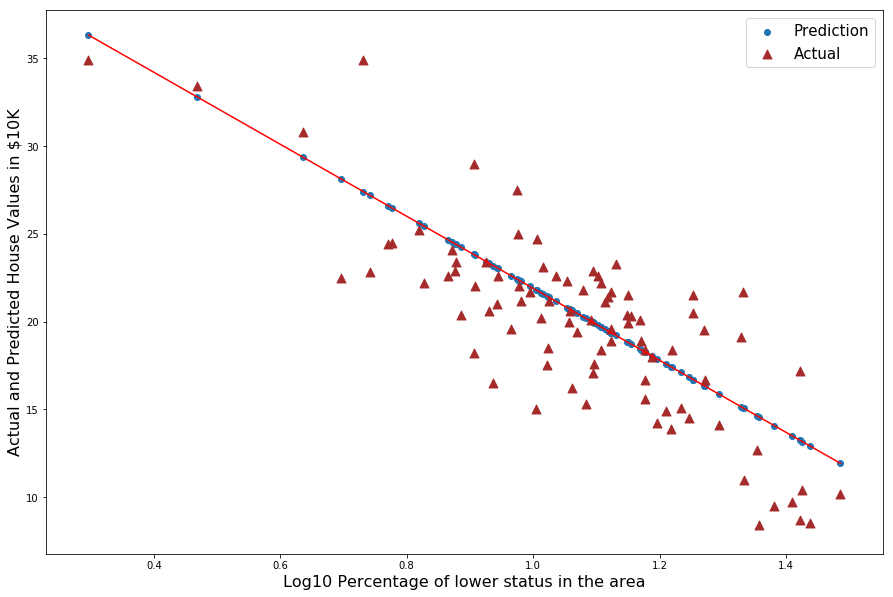

In [48]:
figure(figsize=(15,10))

line = newlstat_coefficient * newlstat_LSTAT.toPandas() + newlstat_intercept

plt.scatter(newlstat_LSTAT.toPandas(), newlstat_predictions.toPandas(), label='Prediction')
plt.scatter(newlstat_LSTAT.toPandas(), newlstat_MEDV.toPandas(), marker='^', s=80, c='brown', label='Actual')
plt.plot(newlstat_LSTAT.toPandas(), line, c='red')
plt.xlabel("Log10 Percentage of lower status in the area", fontsize = 16)
plt.ylabel("Actual and Predicted House Values in $10K", fontsize =16)
plt.legend(fontsize=15);

## We can see now that with the log10(LSTAT), there is a straight-line pattern